In [88]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

import numpy as np
import pandas as pd
import random

## EDA

In [89]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
ba = AllenAtlas()
pid = '6eb8be8d-d089-43c6-b2e4-a6558ca16dcf'
eid = '9e9c6fc0-4769-4d83-9ea4-b59a1230510e'

In [90]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

In [91]:
spikes

{'depths': array([2800.25170898, 3361.30664062, 2904.30395508, ..., 2028.19030762,
        3678.875     , 3317.64160156]),
 'clusters': array([155, 245, 392, ..., 105, 330, 232], dtype=uint32),
 'amps': array([5.56051677e-05, 1.42381795e-04, 5.43605668e-05, ...,
        8.33171788e-05, 3.97071509e-05, 9.17442225e-05]),
 'times': array([1.66376258e-02, 1.72376258e-02, 1.87042924e-02, ...,
        6.55829322e+03, 6.55829669e+03, 6.55830292e+03])}

In [92]:
# the channels are the physicals probes of the neuropixels. There are 384 probes, hence 384 channels
channels['x'].shape

(384,)

In [93]:
spikes['clusters'][spikes['clusters']==4].shape

(5494,)

In [94]:
spikes['times'].max()

6558.302919443709

In [95]:
spikes.keys()

dict_keys(['depths', 'clusters', 'amps', 'times'])

In [96]:
clusters.keys()

dict_keys(['uuids', 'channels', 'depths', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

In [97]:
for i in clusters:
    print(i, ": ", clusters[i][-105:])

uuids :  383    00634996-716b-4010-9b6c-de6a1eec38b8
384    0ac63ce5-c849-4f72-8535-f646e3b14827
385    51c5ac26-e5d1-48e7-a739-51f182df86f2
386    2c9d476b-5f32-4271-a65f-b6167a4b18aa
387    f1102729-02ed-4d74-9150-63f336509088
                       ...                 
483    e2b5a670-64b6-42f6-93b4-d9c42552ee89
484    b2eb692d-d583-4077-9a1e-c80ff4bf307f
485    e534b8d9-e82a-4ec0-8760-1fe7f35fffb4
486    9803e17b-0bd8-4980-a5ca-d5f4d3df5325
487    7f376dcc-acac-4286-aeca-a822070f7fb0
Name: uuids, Length: 105, dtype: object
channels :  [244 250 250 259 266 270 271 281 281 291 294 295 295 304 305 309 305 308
 310 313 325 321 321 321 325 327 327 331 333 334 338 337 337 338 338 343
 344 344 345 345 345 346 346 346 345 350 352 352 352 354 356 356 357 358
 358 358 360 361 361 360 363 365 361 365 367 367 367 369 369 367 370  34
 244 242 246 266 270 270 294 295 305 305 305 305 316 325 317 333 338 345
 358 358 363 363 365 367  34 244 295 305 321 321 333 363 333]
depths :  [2460. 2520. 2520.

In [98]:
trials.keys()

dict_keys(['goCueTrigger_times', 'stimOff_times', 'response_times', 'feedbackType', 'stimOn_times', 'contrastLeft', 'goCue_times', 'feedback_times', 'rewardVolume', 'contrastRight', 'firstMovement_times', 'choice', 'probabilityLeft', 'intervals'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-12-03_1_ZFM-01576_probe00, 6eb8be8d-d089-43c6-b2e4-a6558ca16dcf \n6_821_862 spikes, 488 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

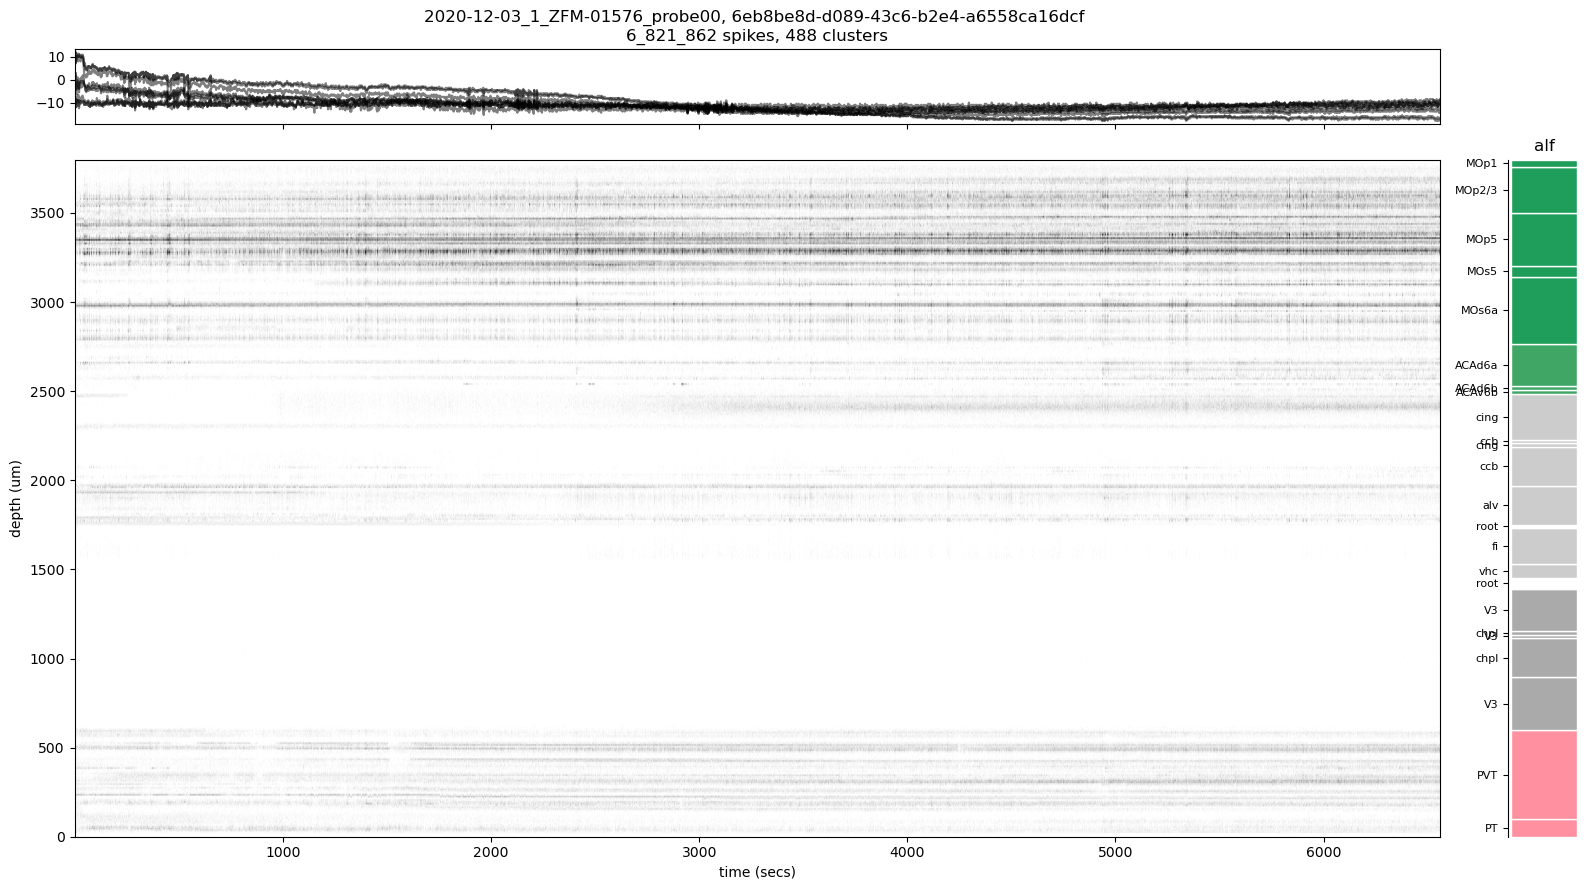

In [99]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons), and for brain regions MOp and MOs
2) Group spikes by neurons
3) Split data across trials
4) Bin spike times for each neuron, for each trial

In [100]:
good_clusterIDs = clusters['cluster_id'][((clusters['label'] == 1) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
# good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters that are in MOp and MOs
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [101]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [102]:
good_spikes

{'depths': array([3361.30664062, 2904.30395508, 3339.80297852, ..., 3219.14282227,
        3339.73730469, 3601.29882812]),
 'clusters': array([245, 392, 237, ..., 211, 237, 302], dtype=uint32),
 'amps': array([1.42381795e-04, 5.43605668e-05, 2.33703407e-04, ...,
        2.80053150e-04, 3.18973675e-04, 1.10413923e-04]),
 'times': array([1.72376258e-02, 1.87042924e-02, 2.07709589e-02, ...,
        6.55828192e+03, 6.55828195e+03, 6.55829135e+03])}

In [103]:
channels.keys()

dict_keys(['x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-12-03_1_ZFM-01576_probe00, 6eb8be8d-d089-43c6-b2e4-a6558ca16dcf \n1_280_696 spikes, 40 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

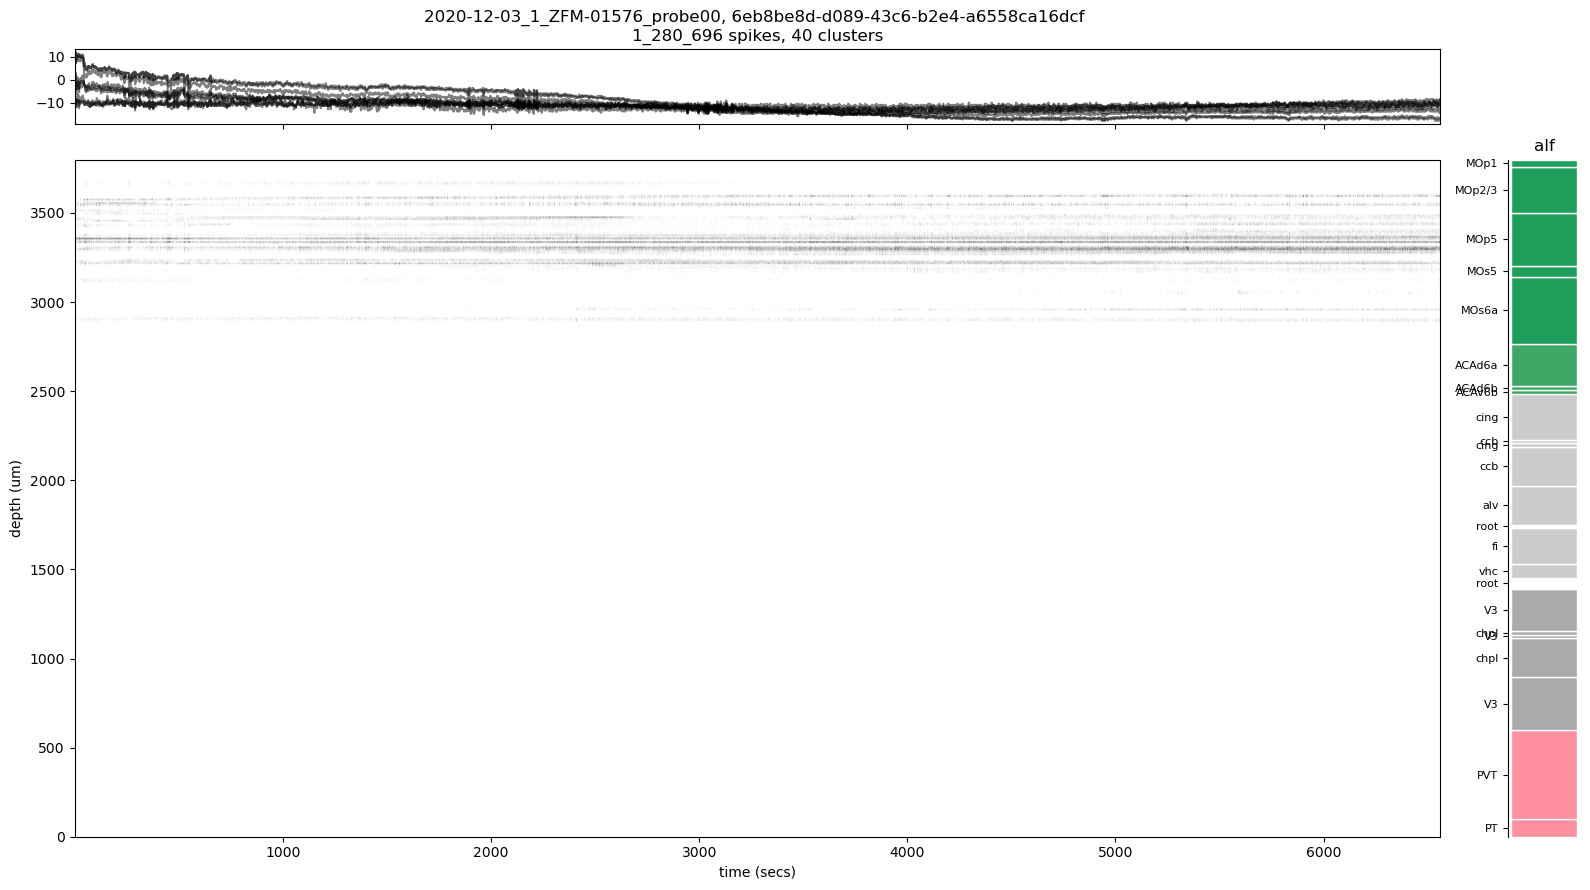

In [104]:
sl.raster(good_spikes, channels)

In [105]:
np.unique(trials['choice'])

array([-1.,  1.])

In [106]:
np.unique(trials['feedbackType'])

array([-1.,  1.])

In [107]:
bin_size = 10e-3 # in milliseconds
# min_bins = max(int((60e-3 / bin_size)), 20)
max_trial_type = 15 # Maximum number of trials of each trial type

In [108]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)

Implementation with bins as a fixed size:

In [109]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
#     try:
#         hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], bin_size)
#     except:
#         continue
#         # the hist bins throw an error if the go cute or first movement time is NaN
#         # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
#     if len(hist_bins) <= min_bins: # Mouse must have a minimum reaction time of 60 ms to be considered a good trial
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], hist_bins)[0])
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with a set number of bins instead of bin size:

In [110]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
    
#     time_range = (trials['firstMovement_times'][i] - trials['goCue_times'][i])
#     if ((time_range < 0.10) | (time_range > 0.300)): # Mouse must have a minimum reaction time of 60 ms to be considered a good trial. We also exlude trials longer than 300 ms because they will have too many spikes per bin
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], 200)[0]) # 200 bins
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with bins starting 100ms before first movement to 300 ms after first movement

In [111]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['firstMovement_times'][i]-0.0, trials['firstMovement_times'][i]+1, bin_size)
    except:
        continue
        # the hist bins throw an error if the go cue or first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    
    for j in df: # Iterate through spike times of each cluster
        inds = ((j>(trials['firstMovement_times'][i]-0.0)) & (j<=(trials['firstMovement_times'][i]+1))) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [112]:
random.shuffle(trials_spikes) # Randomize list before splitting into training and testing data

In [113]:
len(trials_spikes)

1005

In [114]:
training_trials = []
testing_trials = []


trial_counts = {"correct_left" : [0, 0],  # [training count, testing count]
                "correct_right" : [0, 0],
                "incorrect_left" : [0, 0], # incorrect left means that the mouse chose left, and it was incorrect
                "incorrect_right": [0, 0]}

for i in trials_spikes:
    if ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if trial_counts['correct_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_left'][0] += 1
        elif trial_counts['correct_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==1)):
        if trial_counts['correct_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_right'][0] += 1
        elif trial_counts['correct_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_right'][1] += 1
        else:
            continue
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_left'][0] += 1
        elif trial_counts['incorrect_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_right'][0] += 1
        elif trial_counts['incorrect_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_right'][1] += 1
        else:
            continue

In [115]:
len(training_trials)

60

In [116]:
# training_trials[0]["spikes_df"]

In [117]:
# trials_spikes = [] # The Spike times and results of each trial

# for i, interval in enumerate(trials['intervals']):
#     time_range = ((good_spikes['times']>interval[0]) & (good_spikes['times']<interval[1])) #Find the spikes corresponding to the current interval
#     spike_range = {}
    
#     for key in good_spikes:
#         spike_range[key] = good_spikes[key][time_range]
        
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
    
#     # Bin Spikes based on time= 0.1 seconds, per cluster
#     df = pd.DataFrame(data={'clusters':spike_range['clusters'], 'times':spike_range['times']})
#     hist_bins = np.arange(interval[0], interval[1], 0.1)
#     df = df.groupby('clusters')['times'].apply(list)
    
#     hist_rows = []
#     for i in df.iloc:
#         hist_rows.append(np.histogram(i, hist_bins)[0])
#     spikes_df = pd.DataFrame(hist_rows, columns=hist_bins[:-1], index=df.index) # Clusters are assumed to be good neurons
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

In [118]:
# sl.raster(trials_spikes[3], channels)

In [119]:
import math

import jax.random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi

In [120]:
training_trials[0]['spikes_df'].T

clusters,166,173,183,198,204,210,211,215,223,225,...,297,301,302,327,392,401,414,421,422,424
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
session = Session(bin_size)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
for i, trial in enumerate(training_trials):
    # print(trial['spikes_df'].T.shape)
    session.add_trial(i, y=trial['spikes_df'].T)

In [122]:
length_scale = 0.005# in seconds
kernel = RBF(scale=1, lengthscale=20*bin_size)

In [123]:
session, params = vi.fit(session, n_factors=3, kernel=kernel, seed=0, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:173: UserWarning:

E: maximum number of iterations reached



EM Iteration 1, 	Loss = -16.6509, 	M step: 3.24s, 	E step: 12.37s


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased



EM Iteration 2, 	Loss = -16.4554, 	M step: 2.17s, 	E step: 9.58s
Inferring


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:408: UserWarning:

EM: loss increased



Trial 0, 	Loss = -21.1754
Trial 1, 	Loss = 15.9479
Trial 2, 	Loss = -19.0461
Trial 3, 	Loss = -18.9763
Trial 4, 	Loss = -18.6933


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 5, 	Loss = -17.6546
Trial 6, 	Loss = -19.5409
Trial 7, 	Loss = -19.7686
Trial 8, 	Loss = -21.5359
Trial 9, 	Loss = -17.6852
Trial 10, 	Loss = -18.9392
Trial 11, 	Loss = -21.3633
Trial 12, 	Loss = -19.6061
Trial 13, 	Loss = 17036.5808
Trial 14, 	Loss = -17.5583
Trial 15, 	Loss = 26480.1244
Trial 16, 	Loss = 7754.6267
Trial 17, 	Loss = -20.6613
Trial 18, 	Loss = -20.7205
Trial 19, 	Loss = -18.2822
Trial 20, 	Loss = 89743.7065
Trial 21, 	Loss = 32972.5492
Trial 22, 	Loss = -18.7177
Trial 23, 	Loss = -18.0239
Trial 24, 	Loss = 8994.7701
Trial 25, 	Loss = -18.2117
Trial 26, 	Loss = -18.3051
Trial 27, 	Loss = 42734.6455
Trial 28, 	Loss = -18.3705
Trial 29, 	Loss = -20.3157
Trial 30, 	Loss = -20.5837
Trial 31, 	Loss = -21.3019
Trial 32, 	Loss = -18.5550
Trial 33, 	Loss = -19.9061
Trial 34, 	Loss = -18.0569
Trial 35, 	Loss = 49674.6166
Trial 36, 	Loss = 63276.4756
Trial 37, 	Loss = 22889.4008
Trial 38, 	Loss = -19.4343
Trial 39, 	Loss = -18.5297
Trial 40, 	Loss = -19.8361
Trial 41, 	Loss

In [124]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

In [125]:
import plotly.express as px

In [126]:
from sklearn.preprocessing import StandardScaler

Trial 0, 	Loss = -21.1754
0
Trial 2, 	Loss = -19.0461
Trial 3, 	Loss = -18.9763


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 4, 	Loss = -18.6933
4
Trial 5, 	Loss = -17.6546
5
Trial 6, 	Loss = -19.5409
6
Trial 7, 	Loss = -19.7686


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



7
Trial 8, 	Loss = -21.5359
Trial 9, 	Loss = -17.6852
Trial 10, 	Loss = -18.9392
10
Trial 13, 	Loss = 17036.5808


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



13
Trial 14, 	Loss = -17.5583
14
Trial 16, 	Loss = 7754.6267
16
Trial 17, 	Loss = -20.6613
Trial 19, 	Loss = -18.2822


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 21, 	Loss = 32972.5492
21
Trial 22, 	Loss = -18.7177
22
Trial 23, 	Loss = -18.0239
23
Trial 24, 	Loss = 8994.7701


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 26, 	Loss = -18.3051
26
Trial 27, 	Loss = 42734.6455
Trial 28, 	Loss = -18.3705
Trial 29, 	Loss = -20.3157


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



29
Trial 30, 	Loss = -20.5837
30
Trial 32, 	Loss = -18.5550
Trial 33, 	Loss = -19.9061
Trial 34, 	Loss = -18.0569


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 35, 	Loss = 49674.6166
Trial 38, 	Loss = -19.4343
Trial 39, 	Loss = -18.5297


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



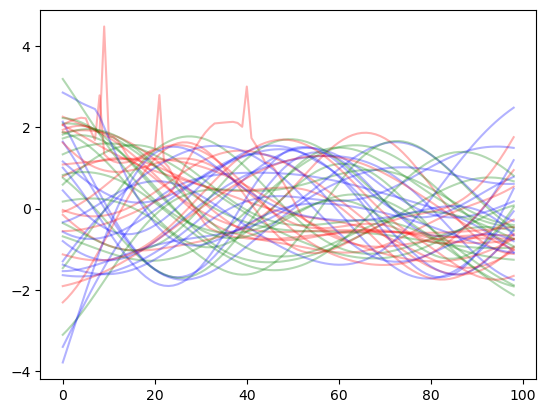

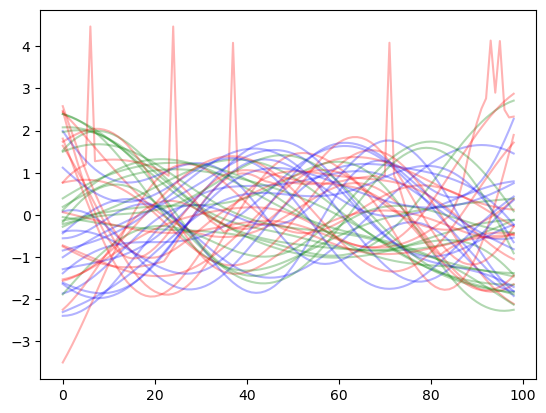

In [127]:
first = True
correct_left = np.array([])
for i, trial in enumerate(training_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        # values = sessionTest.z
        print(i)
        if first:
            fig = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["blue"]*len(values), width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)
            
        fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'black', 'size':5}) # Marks the end point of the trial
        plt.figure(1)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
        
    elif ((trial['choice']==-1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        # values = sessionTest.z
        if first:
            fig  = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["red"]*len(values), width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)
        fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'green', 'size':5}) # Marks the end point of the trial
        plt.figure(2)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
fig.show()
plt.show()

In [128]:
fig  = px.line_3d(x=session.z[:, 0], y=session.z[:, 1], z=session.z[:, 2], color=["blue"]*len(session.z), width=800, height=800)
fig.show()

In [148]:
first = True
correct_left = []
correct_right = []

for i, trial in enumerate(training_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        correct_right.append(values)
        # values = sessionTest.z
        # print(i)
        # if first:
        #     fig = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["blue"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)
            
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'black', 'size':5}) # Marks the end point of the trial
        # plt.figure(1)
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
        
    elif ((trial['choice']==-1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        correct_left.append(values)
        # values = sessionTest.z
        # if first:
        #     fig  = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["red"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'green', 'size':5}) # Marks the end point of the trial
        # plt.figure(2)
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
# fig.show()
# plt.show()

Trial 0, 	Loss = -21.1754
Trial 2, 	Loss = -19.0461
Trial 3, 	Loss = -18.9763
Trial 4, 	Loss = -18.6933


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 5, 	Loss = -17.6546
Trial 6, 	Loss = -19.5409
Trial 7, 	Loss = -19.7686
Trial 8, 	Loss = -21.5359


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 9, 	Loss = -17.6852
Trial 10, 	Loss = -18.9392
Trial 13, 	Loss = 17036.5808
Trial 14, 	Loss = -17.5583


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 16, 	Loss = 7754.6267
Trial 17, 	Loss = -20.6613
Trial 19, 	Loss = -18.2822
Trial 21, 	Loss = 32972.5492


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 22, 	Loss = -18.7177
Trial 23, 	Loss = -18.0239
Trial 24, 	Loss = 8994.7701
Trial 26, 	Loss = -18.3051


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 27, 	Loss = 42734.6455
Trial 28, 	Loss = -18.3705
Trial 29, 	Loss = -20.3157
Trial 30, 	Loss = -20.5837


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 32, 	Loss = -18.5550
Trial 33, 	Loss = -19.9061
Trial 34, 	Loss = -18.0569
Trial 35, 	Loss = 49674.6166


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 38, 	Loss = -19.4343
Trial 39, 	Loss = -18.5297


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



In [149]:
correct_right_m = np.array(correct_right).mean(axis=0)
correct_left_m = np.array(correct_left).mean(axis=0)

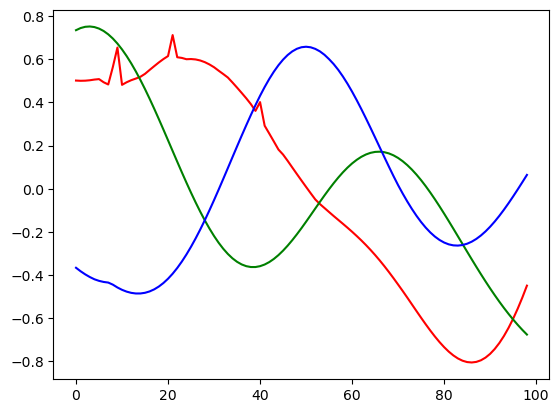

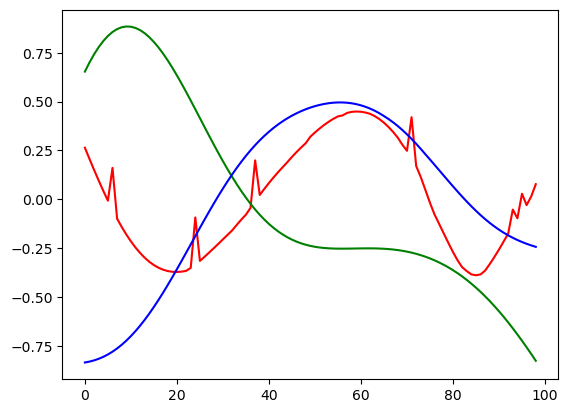

In [155]:
plt.figure(3)
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 0], color='red')
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 1], color='green')
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 2], color='blue')
plt.figure(4)
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 0], color='red')
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 1], color='green')
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 2], color='blue')

Trial 0, 	Loss = -17.9732
Trial 1, 	Loss = -19.7370
Trial 2, 	Loss = -19.3190


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 3, 	Loss = -17.9609
Trial 4, 	Loss = -19.1506
Trial 5, 	Loss = -17.2803
Trial 6, 	Loss = -21.4031


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 7, 	Loss = -19.1916
Trial 8, 	Loss = -18.9550
Trial 9, 	Loss = -18.1917
Trial 11, 	Loss = -14.1985


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 12, 	Loss = -19.0897
Trial 16, 	Loss = -18.6909
Trial 17, 	Loss = -17.9361
Trial 18, 	Loss = -19.1365


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



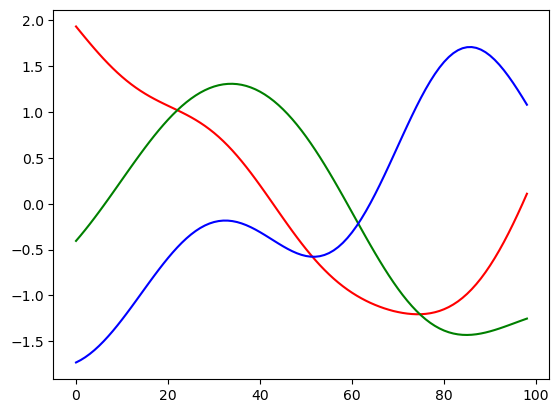

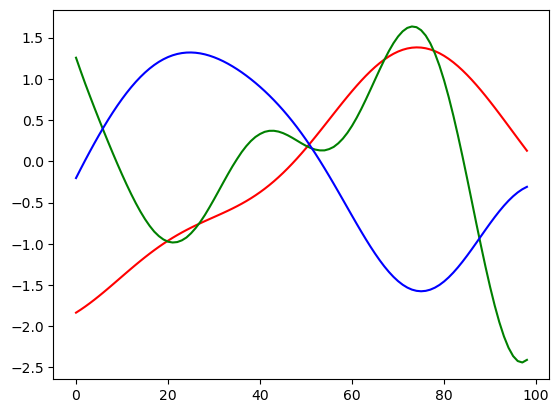

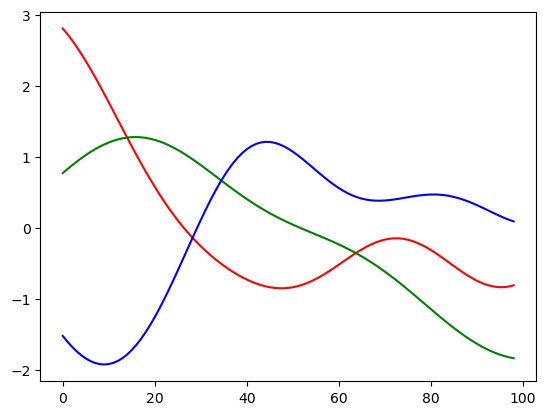

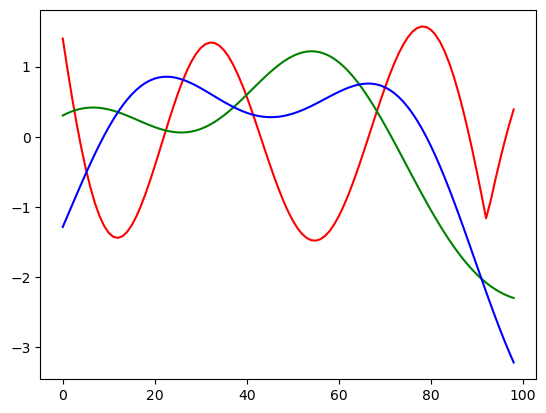

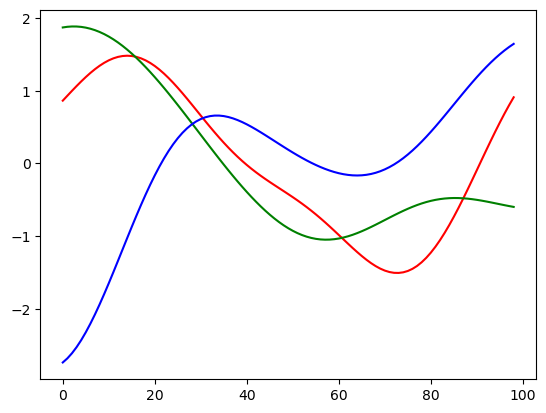

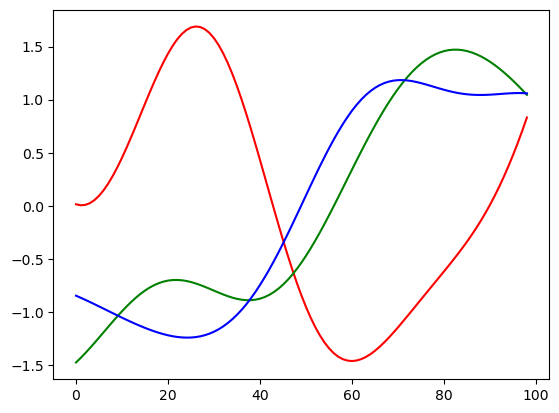

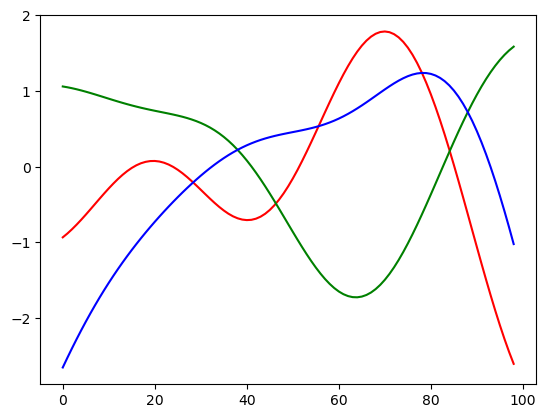

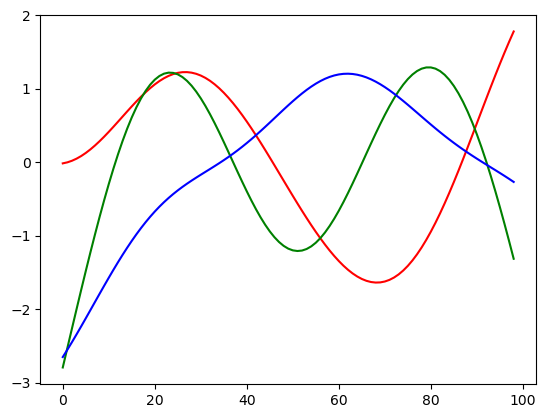

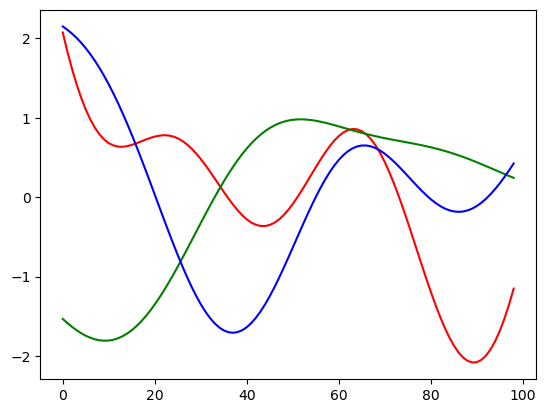

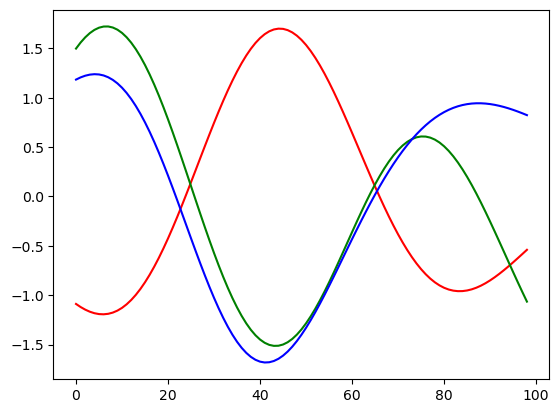

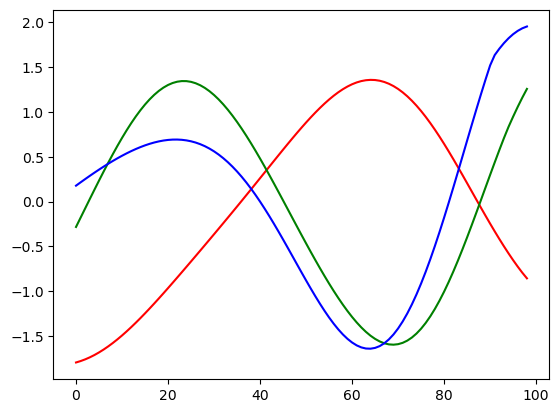

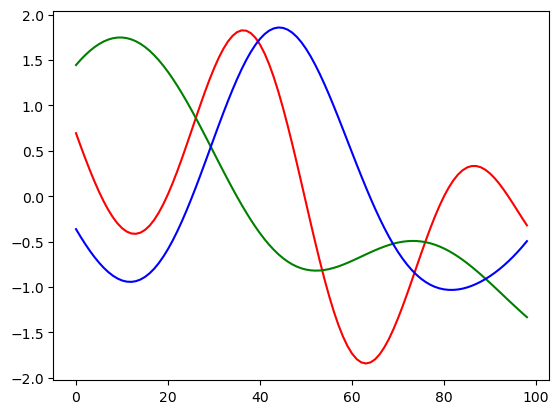

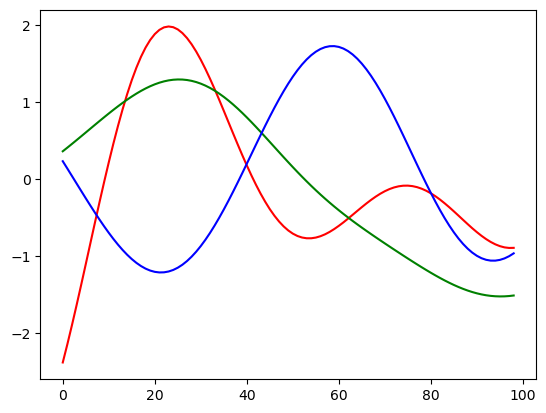

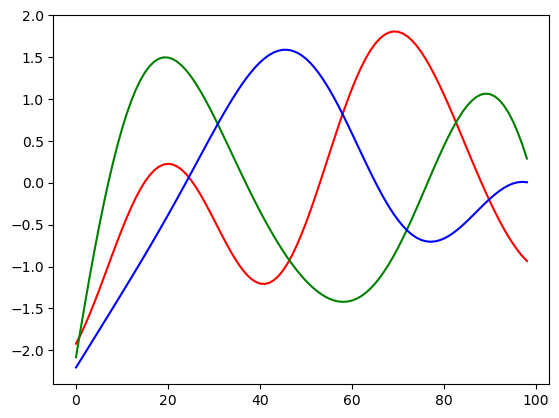

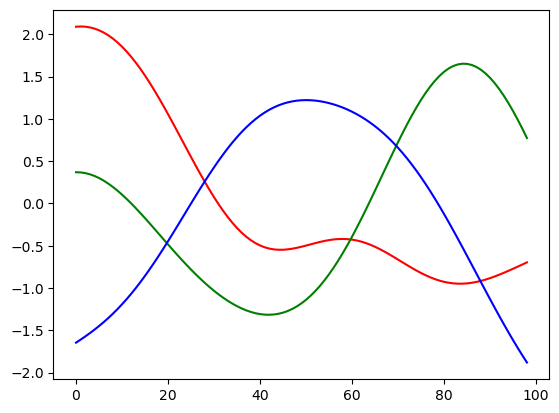

In [153]:
for i, trial in enumerate(testing_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        plt.figure(i)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red')
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green')
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue')

In [144]:
len(correct_left)

99

In [147]:
correct_right

array([-4.81096644e-16, -8.41078049e-17, -1.73682617e-16])